Autorzy:   
Bartosz Świrta  
Radosław Radziukiewicz

# Na jakie dane będziemy zwracać uwagę?

Ponieważ naszym zadaniem jest skonstruowanie systemu rekomendującego **produkty użytkownikom na podstawie ich sesji**,
będziemy potrzebowali danych użytkowników obecnych w systemie sklepu eSzoping, wraz z ich listą intreakcji.

---

### Dane użytkowników

Dane użytkowników zawarte są w pliku **users.jsonl**.

Pojedynczy rekord opisujący użytkownika składa się z następujących kolumn:
- id użytkownika w systemie
- imię użytkownika
- miasto zamieszkania
- adres zamieszkania

Przypuszczalnie, nie wszystkie informacje zawarte w rekordach będą dla nas użyteczne. Dalsza analiza oceni przydatność poszczególnych atrybutów.

---

### Dane produktów

Dane związane z produktami zawarte są w pliku **products.jsonl**.

Pojedynczy rekord opisujący produkt składa się z następujących kolumn:
- id produktu w systemie
- nazwa produktu
- kategoria przynależności produktu
- cena produktu
- ocena produktu

Przypuszczalnie, nie wszystkie informacje zawarte w rekordach będą dla nas użyteczne. Dalsza analiza oceni przydatność poszczególnych atrybutów.

---


### Dane sesji

Dane łączące użytkowników z produktami zawarte są w pliku **sessions.jsonl**.
Plik ten zawiera rekordy opisujące aktywności użytkowników w obrębie strony eSzoping.

Pojedynczy rekord opisujący akcję użytkownika w systemie składa się z następujących kolumn:
- id sesji w systemie
- punkt w czasie odbycia się aktywności
- id użytkownika którego dotyczy wydarzenie
- id produktu którego dotyczy wydarzenie
- typ wydarzenia
- informacja o oferowanej zniżce
- id dokonanego zakupu

Aby wydobyć "pełnię" informacji odnośnie sesji, będziemy musieli uwzględnić pliki opisujące **produkty i użytkowników** w analizie danych sesji.

Przypuszczalnie, nie wszystkie informacje zawarte w rekordach będą dla nas użyteczne. Dalsza analiza oceni przydatność poszczególnych atrybutów.

---

### Nieistotne dane

Dane, których nie użyjemy w trakcie analizy, to te zawarte w pliku **deliveries.jsonl**. Plik ten zawiera rekordy opisujące zdarzenia dowozu produktu do kupującego. Zakładamy, iż dane te są nieistotne z punktu widzenia interakcji użytkownika ze sklepem internetowym.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Used for verbose data presentation.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

usersDataPath = './data/v2/users.jsonl'
productsDataPath = './data/v2/products.jsonl'
sessionsDataPath = './data/v2/sessions.jsonl'

usersDF = pd.read_json(usersDataPath, lines=True)
sessionsDF = pd.read_json(sessionsDataPath, lines=True)
productsDF = pd.read_json(productsDataPath, lines=True)

# Analiza samodzielnych danych

Teraz dokładnie przyjrzymy się danym które mogą być analizowane samodzielnie. Zbadamy typy ich atrybutów, rozkłady oraz podejmiemy pierwsze decyzje modelowania danych.

## Dane produktów

Aby mieć lepsze "poczucie" analizowanych danych, poniżej prezentujemy 10 pierwszych rekordów obecnych w dostarczonych danych.

In [2]:
productsDF.head(n=10)

,product_id,product_name,category_path,price,user_rating
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,4.625003
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,2048.50,1.875949
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,7639.00,1.493143
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,4.063970
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,2.949198
5,1006,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90,3.054270
6,1007,Dead Space 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,89.99,3.995136
7,1008,Tom Clancy&#39;s Rainbow Six Vegas (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,3.715598
8,1009,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69.00,4.801920
9,1010,BioShock 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,89.99,3.510874


Już z tych przykładowych danych możemy wyciągnąć kilka interesujących wniosków. Po pierwsze, ceny produktów mogę w sposób znaczący różnić się między sobą (58.97 kontra 7639.00). Po drugie, nazwa produktu wydaje się być zbędna w momencie posiadania jego identyfikatora (jest ona po prostu kolejnym unikatowym ciągiem znaków). Po trzecie, i to jest najabardziej istotny wniosek, kolumna **category_path** zawiera informację o kategorii produktu w formie "doprecyzowywania" tzn. kategorie rozdzielane są znakiem **;** a najistotniejsza kategoria umieszczona jest na samym początku napisu.

In [3]:
productsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
 4   user_rating    319 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 12.6+ KB


Widzimy, iż dane produktów nie zawierają żadnych brakujących wartości. 

Dane produktów zawierają dwie kolumny o typie napisowym (product_name oraz category_path), jedną o typie całkowitym (product_id) oraz dwie o typie zmiennoprzecinkowym (price i user_rating).

### Identyfikatory produktu

W celu lepszego zaznajomienia się z danymi opisującymi identyfikator produktu dokonujemy dalszej analizy kolumny **product_id**.

In [4]:
print('Max id of the product is: {}'.format(productsDF['product_id'].max()))
print('Min id of the product is: {}'.format(productsDF['product_id'].min()))
print('Disctinct id count is: {}'.format(productsDF['product_id'].nunique()))

Max id of the product is: 1319
Min id of the product is: 1001
Disctinct id count is: 319


Jak widzimy, minimalnym identyfikatorem produktu jest wartość **1001** a maksymalnym wartość **1319**. Ponadto wszystkie wartości pomiędzy **1001 a 1319** są osiągane dokładnie 1 raz.

### Nazwy produktu

Następnie analizie poddamy kolumnę opisującą nazwę produktu **product_name**.

In [5]:
print('Distinct name count is: {}'.format(productsDF['product_name'].nunique()))

Distinct name count is: 319


Widzimy, iż w naszych danych nie występują produkty o tych samych nazwach.

### Scieżka kategorii

Teraz analizie poddamy kolumnę opisującą scieżkę kategorii produktu **category_path**. W tym celu przyjrzymy się dostępnym ścieżkom kategorii oraz liczności każdej z nich tzn. ile produktów należy do danej ścieżki.

In [6]:
print(productsDF['category_path'].drop_duplicates().reset_index(drop=True).sort_values().to_string(index=False))

                                    Gry i konsole;Gry komputerowe
                    Gry i konsole;Gry na konsole;Gry PlayStation3
                        Gry i konsole;Gry na konsole;Gry Xbox 360
   Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne
                                  Komputery;Monitory;Monitory LCD
                            Komputery;Tablety i akcesoria;Tablety
                                       Sprzęt RTV;Audio;Słuchawki
         Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4
                                 Sprzęt RTV;Video;Odtwarzacze DVD
               Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV
               Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące
  Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe
                          Telefony i akcesoria;Telefony komórkowe
                        Telefony i akcesoria;Telefony stacjonarne


Zauważamy, że ścieżki kategorii tworzą hierarchię. Każda kategoria ma swój korzeń, który jest rozwijany poprzez ewentualne dopisywanie nowych podkategorii.

In [7]:
productsDF.groupby('category_path')['product_id'].count().sort_values(ascending=False)

category_path
Gry i konsole;Gry komputerowe                                        202
Gry i konsole;Gry na konsole;Gry Xbox 360                             32
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                    30
Komputery;Monitory;Monitory LCD                                       17
Gry i konsole;Gry na konsole;Gry PlayStation3                          9
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne         9
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące      5
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe        4
Komputery;Tablety i akcesoria;Tablety                                  2
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4               2
Sprzęt RTV;Video;Odtwarzacze DVD                                       2
Telefony i akcesoria;Telefony komórkowe                                2
Sprzęt RTV;Audio;Słuchawki                                             1
Sprzęt RTV;Video;Telewizory i akcesor

Powyższy wynik ukazuje nam, że liczba produktów w kategoriach nie jest rozłożona w sposób równomierny. Niektóre kategorie posiadają jedynie jeden zakwalifikowany produkt, podczas gdy inne zawierają ich aż kilkadziesiąt lub kilkaset. Proponowanym rozwiązaniem będzie zmieniejszenie liczby dostępnych kategorii poprzez rzutowanie danych na odpowiedni korzeń hierarchi kategorii. 

Poprzez rzutowanie moglibyśmy otrzymać następujące wyniki:
- "Gry komputerowe": 202
- "Gry na konsole": 41 (Xbox and PS3)
- "Sprzęt RTV": 36
- "Komputery": 28
- "Telefony i akcesoria": 12

Liczba i liczność wytworzonych kategorii wydaje się być zadowalająca na ten moment.

In [8]:
separator = ';'
newGroups = ['Gry komputerowe', 'Gry na konsole', 'Sprzęt RTV', 'Komputery', 'Telefony i akcesoria']

def castCategoryPath(categoryPath):
    categories = categoryPath.split(separator)
    foundGroups = [group for group in newGroups if group in categories]
    if len(foundGroups) != 1:
        raise RuntimeError('wrong group cast: {}'.format(foundGroups))
    return foundGroups[0]

transformed = productsDF['category_path'].apply(castCategoryPath)
print(transformed.value_counts())

Gry komputerowe         202
Gry na konsole           41
Sprzęt RTV               36
Komputery                28
Telefony i akcesoria     12
Name: category_path, dtype: int64


### Cena produktu

Poniżej przedstawiamy histogram prezentujący rozkład wartości cen zawartych w kolumnie **price**.

Max price is: 7639.0
Min price is: 1.0


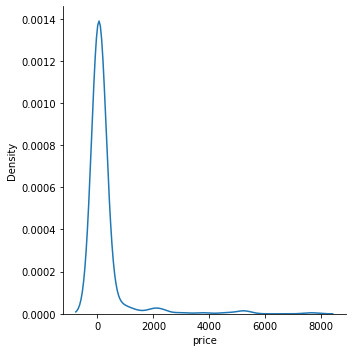

In [9]:
print('Max price is: {}'.format(productsDF['price'].max()))
print('Min price is: {}'.format(productsDF['price'].min()))

sns.displot(data=productsDF, x="price", kind="kde")

<AxesSubplot:xlabel='price'>

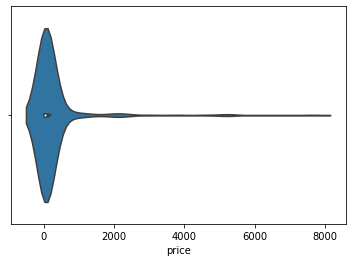

In [10]:
sns.violinplot(data=productsDF, x='price')

Widzimy, że zdecydowana większość cen mieści się poniżej kwoty 100. Niestety, wartości odstające zakłócają wygląd wykresów. Decydujemy się rozbić produkty na tańsze i droższe. Jako punkt podziału przyjmujemy wartość 100. 

Cheap products amount is: 247
Expensie products amount is: 72


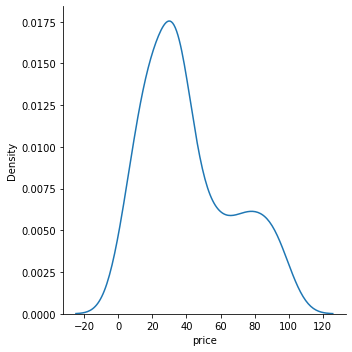

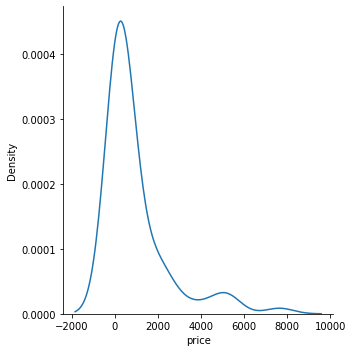

In [11]:
threshold = 100

cheapProducts = (productsDF.loc[productsDF['price'] < threshold], 'Cheap')
expensiveProducts = (productsDF.loc[productsDF['price'] >= threshold], 'Expensie')

productsSplit = [cheapProducts, expensiveProducts]

for ps in productsSplit:
    print('{} products amount is: {}'.format(ps[1], ps[0]['price'].count()))
    sns.displot(data=ps[0], x="price", kind="kde")

Jak widzimy, wartości zmiennej opisującej ceny produktu nie są rozłożone w sposób równomierny. Przypominają jednak złożenia kilku rozkładów normalnych których wartości oczekiwane i wariancje są różne. Interesujące wydają nam się również produkty z ceną 1.0. Postanawiamy przyjrzeć się rekordom z taką ceną.

In [12]:
productsDF.loc[productsDF["price"] == productsDF["price"].min()]

,product_id,product_name,category_path,price,user_rating
140,1141,Król Futbolu Piłkarski Quiz (PC),Gry i konsole;Gry komputerowe,1.0,4.769109
192,1193,Heroes Over Europe (PC),Gry i konsole;Gry komputerowe,1.0,0.643202
271,1272,The Ball (PC),Gry i konsole;Gry komputerowe,1.0,3.863771


Powyższe pozycje, choć zastanawiające, są możliwe.

### Ocena produktu

Poniżej prezentujemy wykres przedstawiający rozkład wartości zmiennych opisujących opinie o produkcie zawartych w kolumnie **user_rating**.

Max rating is: 4.979449037424941
Min rating is: 0.02034268681253


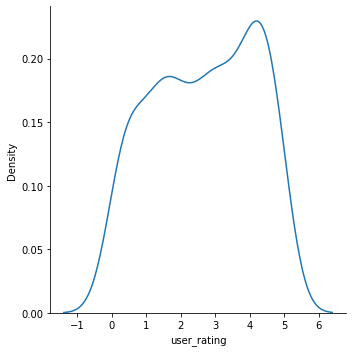

In [13]:
print('Max rating is: {}'.format(productsDF['user_rating'].max()))
print('Min rating is: {}'.format(productsDF['user_rating'].min()))

sns.displot(data=productsDF, x='user_rating', kind='kde')

Jak widać, opinie o produktach rozłożone są w sposób bardziej równomierny niż ceny produktów. Ponadto, wszystkie wartości z kolumny **user_rating** zawarte są w przedziale (0,5).

## Dane użytkowników

Podobnie jak w przypadku analizy danych o produktach, przyjrzyjmy się przykładowym wpisom w dostępnych danych:

In [14]:
usersDF.head(n=10)

,user_id,name,city,street
0,102,Hubert Rybus,Warszawa,aleja Popiełuszki 640
1,103,Dominik Sławik,Wrocław,plac Sportowa 575
2,104,Nataniel Niećko,Poznań,pl. Szymanowskiego 87
3,105,Kajetan Sieradzan,Szczecin,ulica Powstańców Wielkopolskich 76/43
4,106,Gabriel Grygorcewicz,Kraków,plac Tęczowa 57
5,107,Kornelia Oleksiuk,Szczecin,pl. Partyzantów 54/71
6,108,Nataniel Maciuk,Radom,ul. Kochanowskiego 78/35
7,109,Dagmara Kurach,Wrocław,plac Wodna 58
8,110,Tomasz Łudzik,Wrocław,ulica Maja 28
9,111,Maciej Zioła,Poznań,al. Śląska 30


Widzimy, że praktycznie wszystkie kolumny posiadają typ napisowy (**name, city, street**). Ponadto, kolumna **street** w rzeczywistości zawiera adres użykownika, a nie ulicę na której mieszka. Pozostałe kolumny wydają się być standardowe w kontekście zawieranych danych.

In [15]:
usersDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  200 non-null    int64 
 1   name     200 non-null    object
 2   city     200 non-null    object
 3   street   200 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


Widzimy, że dane użytkowników nie zawierają żadnych brakujących wartości. Wszystkie wpisy są kompletne.

### Identyfikator użytkownika

Teraz przyjrzymy się wartościom zawartym w kolumnie **user_id**. Interesuje nas, czy wszystkie wartości są unikalne. Ponadto dobrze byłoby znać zakres identyfikatorów, oraz czy jest on w pełni zapełniony.

In [16]:
print('Max user id is: {}'.format(usersDF['user_id'].max()))
print('Min user id is: {}'.format(usersDF['user_id'].min()))
print('Unique identifiers number is: {}'.format(usersDF['user_id'].nunique()))

Max user id is: 301
Min user id is: 102
Unique identifiers number is: 200


Z powyższych wyników wnioskujemy, że zakres identyfikatorów wynosi [102, 301] Ponadto, każda wartość w tym zakresie przyjmowana jest dokładnie jeden raz.

### Imię użytkownika

Następną kolumną, jaką poddamy dalszej analizie, jest ta zawierająca informacje o imieniu użytkownika. Jesteśmy zainteresowani, czy w dostępnych danych istnieje duplikacja użytkownika (różne identyfikatory ale to samo imię i nazwisko).

In [17]:
print('Unique name count is: {}'.format(usersDF['name'].nunique()))

Unique name count is: 200


Jak widać, wszystkie imiona użytkowników są unikatowe. Dzięki temu, jesteśmy w stanie stwierdzić, że w zbiorze danych nie występują potencjalne anomalie. Poza tym zakładamy, że kolumna o nazwie **name** nie wnosi żadnych nowych informacji do modelu i rozwiązywanego zagadnienia. 

### Miasto zamieszkania

Kolumna zawierająca miasto zamieszkania użytkownika (zakładamy, że jest to miejsce zamieszkania, jednak nie mamy tutaj żadnej pewności co do tego) wydaje się nieść potencjalnie wiele przydatnych informacji. Przede wszystkim dzięki niej jesteśmy w stanie stwierdzić, czy zbiór użytkowników na których operujemy, jest reprezentatywny. Ponadto potencjalnie może zachodzić korelacja pomiędzy miastem zamieszkania a zainteresowaniem pewnymi produktami przez grupy użytkowników. Poniżej prezentujemy histogram z uzyskanymi wynikami.

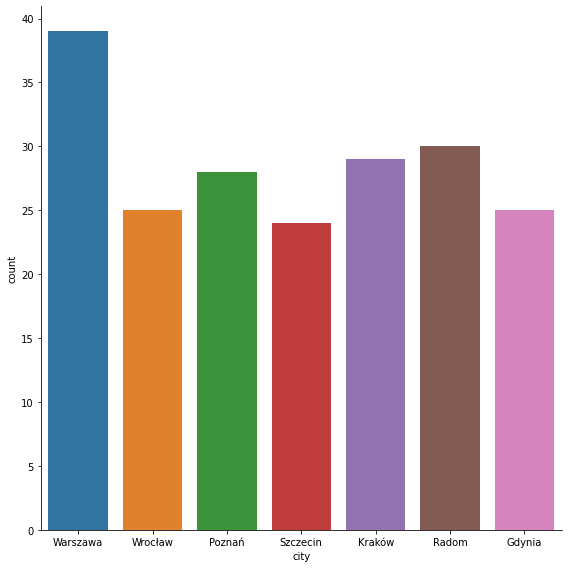

In [18]:
sns.catplot(data=usersDF, kind='count', x='city', height=8)

Z powyższego histogramu widzimy, iż pomimo pewnych nieregularności, dane są rozłożone dość równomiernie. Dzięki temu, jesteśmy w stanie stwierdzić, że dane na których pracujemy, są reprezentatywne

### Adres zamieszkania

Ostatnią kolumną do przeanalizowania jest ta zawierająca dane o adresach zamieszkania użytkowników. Zakładamy, iż prawdopodobnie kolumna to nie będzie dla nas w żaden sposób informatywna. Tym nie mniej, jesteśmy zainteresowani, czy w danych nie występuje duplikacja adresu.

In [19]:
print('Unique address count is: {}'.format(usersDF['street'].nunique()))

Unique address count is: 200


Jak widać, wszystkie adresu są unikatowe.

## Dane sesji

Przyjrzyjmy się nieco bliżej danym sesji.

In [20]:
sessionsDF.head(10)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2020-03-17 21:55:02,102,1148,VIEW_PRODUCT,15,NaN
1,124,2020-03-17 21:59:51,102,1054,VIEW_PRODUCT,15,NaN
2,124,2020-03-17 22:00:12,102,1054,BUY_PRODUCT,15,20001.0
3,125,2020-08-29 21:34:55,102,1046,VIEW_PRODUCT,0,NaN
4,125,2020-08-29 21:35:46,102,1084,VIEW_PRODUCT,0,NaN
5,125,2020-08-29 21:39:53,102,1276,VIEW_PRODUCT,0,NaN
6,125,2020-08-29 21:43:47,102,1276,VIEW_PRODUCT,0,NaN
7,125,2020-08-29 21:48:11,102,1276,BUY_PRODUCT,0,20002.0
8,126,2021-05-07 17:33:16,102,1017,VIEW_PRODUCT,0,NaN
9,126,2021-05-07 17:37:59,102,1025,VIEW_PRODUCT,0,NaN


Widzimy, że dane sesji nie zawierają bezpośrednio informacji o użytkownikach  i produktach, a jedynie ich unikalne identyfikatory. Stwierdzamy, iż w celu dokonania lepszej analizy powinniśmy dołączyć do danych sesji odpowiadające dane z tabeli o użytkownikach i produktach.

W tej sekcji postanowiliśmy odpowiedzieć sobie na kilka pytań istotnych z punktu widzenia zadania:
- Czy istnieje użytkownik nie posiadający żadnej sesji?
- Czy istnieje produkt, który nie został przez nikogo wyświetlony?
- Czy dane użytkowników i produktów są pełne, tj. czy w danych sesji jest produkt bądź użytkownik, który nie widnieje w innych dostarczonych danych.

Przy łączeniu danych wykorzystaliśmy **outer join** by wszelkie braki w danych były proste do wychwycenia.

In [21]:
# Use outer join in order to keep all values from data frames.
mergedDF = pd.merge(sessionsDF, usersDF, how='outer', on='user_id')
mergedDF = pd.merge(mergedDF, productsDF, how='outer', on='product_id')

print(sessionsDF.shape[0] == mergedDF.shape[0])
mergedDF.info()

True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116050 entries, 0 to 116049
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   session_id        116050 non-null  int64         
 1   timestamp         116050 non-null  datetime64[ns]
 2   user_id           116050 non-null  int64         
 3   product_id        116050 non-null  int64         
 4   event_type        116050 non-null  object        
 5   offered_discount  116050 non-null  int64         
 6   purchase_id       10692 non-null   float64       
 7   name              116050 non-null  object        
 8   city              116050 non-null  object        
 9   street            116050 non-null  object        
 10  product_name      116050 non-null  object        
 11  category_path     116050 non-null  object        
 12  price             116050 non-null  float64       
 13  user_rating       116050 non-null  float64       
dtyp

Stwierdzamy, iż dane nie zawierają anomali (brak nieznanych użytkowników i produktów).
Dodatkowo obserwujemy, że użytkownicy częściej przeglądają produkty, niż je kupują. Stosunek obu rodzajów aktywności wynosi 105358:10692.

Obszary którym przyjrzymy się nieco dokładniej w dalszej części:
- session_id - stwierdzenie liczby unikalnych sesji, sprawdzenie czy nie występują błędne dane (np. ujemne identyfikatory)
- timestamp - sprawdzenie przedziału czasu z jakiego pochodzą dane
- analiza danych sesji - jakie są najpopularniejsze kategorie, produkty itp.
- gęstość macierzy interakcji

### Identyfikator sesji

Poszukujemy błędów w atrybucie **session_id**, takich jak wartości ujemne czy duplikacja.

In [22]:
print(f"Minimum session id: {sessionsDF['session_id'].min()}")
print(f"Maximum session id: {sessionsDF['session_id'].max()}")
print(f"Number of unique sessions: {sessionsDF['session_id'].nunique()}")

Minimum session id: 124
Maximum session id: 19726
Number of unique sessions: 19603


Wartości w kolumnie **session_id** są poprawne. Liczba 19603 unikalnych sesji jest również pokaźnym zbiorem danych. 

### Sprawdzenie przedziału czasowego

Dla naszego problemu istotne jest sprawdzenie czy dane pochodzą z odpowiednio długiego okresu. Uważamy, że minimalny przedział pokryty przez dane powinien wynosić 1 rok. Dodatkowo, zweryfikujemy czy okres pokryty jest w całości (tzn. czy nie występują okresy z brakiem danych).

In [23]:
byDaySessionsDF = sessionsDF.groupby(pd.Grouper(key='timestamp', axis=0, freq='1D', sort=True))
print(f"Days count in data: {byDaySessionsDF.size().count()}")
print(f"first date: {byDaySessionsDF.count().head(1)}\nlast date: {byDaySessionsDF.count().tail(1)}")

Days count in data: 731
first date:             session_id  user_id  product_id  event_type  offered_discount  \
timestamp                                                                   
2019-12-11         106      106         106         106               106   

            purchase_id  
timestamp                
2019-12-11            5  
last date:             session_id  user_id  product_id  event_type  offered_discount  \
timestamp                                                                   
2021-12-10         158      158         158         158               158   

            purchase_id  
timestamp                
2021-12-10           13  


Dane pochodzą z 2 lat, a dokładnie z okresu od **11.12.2019 do 10.12.2022**, w danych nie występują przerwy. Oznacza to, że dane są reprezentatywne i mogą być wykorzystane do rozwiązania zadania.

### Popularność produktów i kategorii

Poniżej sprawdzamy jak często każdy z produktów występuję w danych. Można rozumieć to jako analizę "popularności" produktów w sklepie.

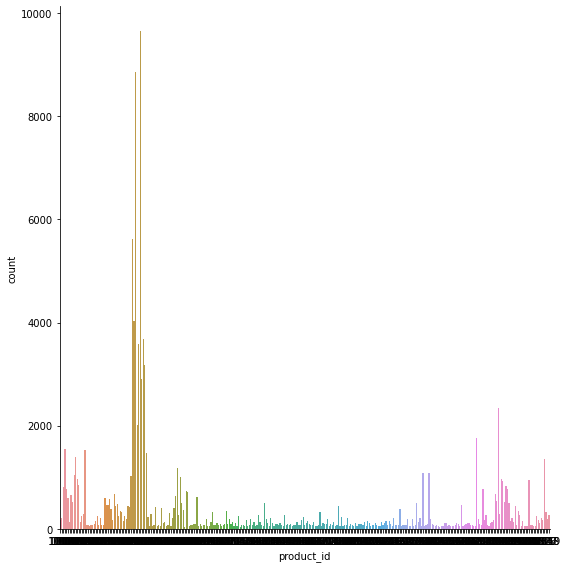

In [24]:
sns.catplot(data=sessionsDF, kind='count', x='product_id', height=8)

Jak widać, w częstości interakcji z produktami istnieje duża dysproporcja. Widzimy, że jedynie niewielki odsetek produktów przyciąga znaczną uwagę użytkowników, podczas gdy większość produktów nie budzi większego zainteresowanie.

Co istotne, każdy z produktów został obejrzany przez choć jednego użytkownika.

Zainteresowało nas, jakie dokładnie produkty są najpopularniejsze i do jakich kategorii należą. Za poziom odcięcia przyjęliśmy 95 percentyl.

count    16.000000
mean      3.145805
max       4.959925
min       0.364934
Name: user_rating, dtype: float64


,product_id,product_name,category_path,price,user_rating
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,4.063970
10,1011,BioShock Infinite (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,139.99,3.251818
16,1017,LCD Dell U2412M,Komputery;Monitory;Monitory LCD,399.00,4.003806
47,1048,Gra o tron (PC),Gry i konsole;Gry komputerowe,63.49,2.346389
48,1049,Max Payne 3 (PC),Gry i konsole;Gry komputerowe,17.90,1.495826
49,1050,Bioshock 2 (PC),Gry i konsole;Gry komputerowe,37.90,4.959925
50,1051,Spec Ops The Line (PC),Gry i konsole;Gry komputerowe,76.90,3.039276
51,1052,Duke Nukem Forever (PC),Gry i konsole;Gry komputerowe,78.90,2.176047
52,1053,Anno 2070 (PC),Gry i konsole;Gry komputerowe,42.90,4.378637
53,1054,Call of Duty 2 (PC),Gry i konsole;Gry komputerowe,32.99,4.628316


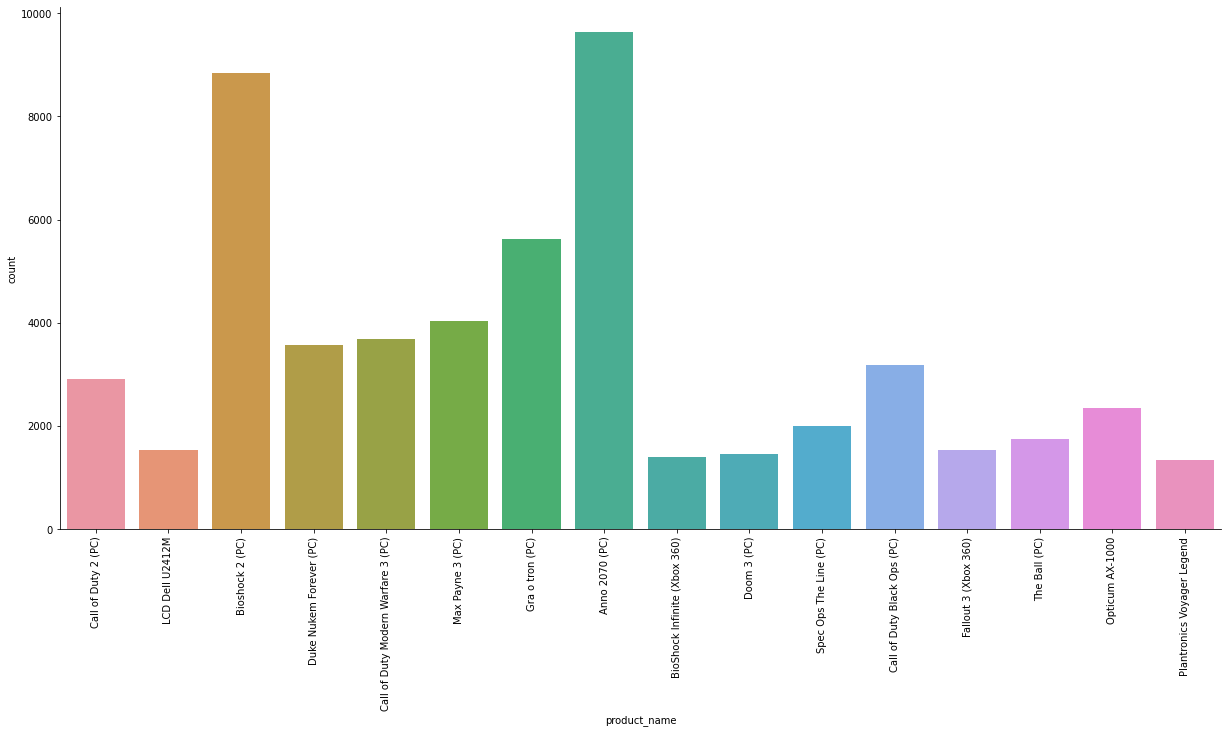

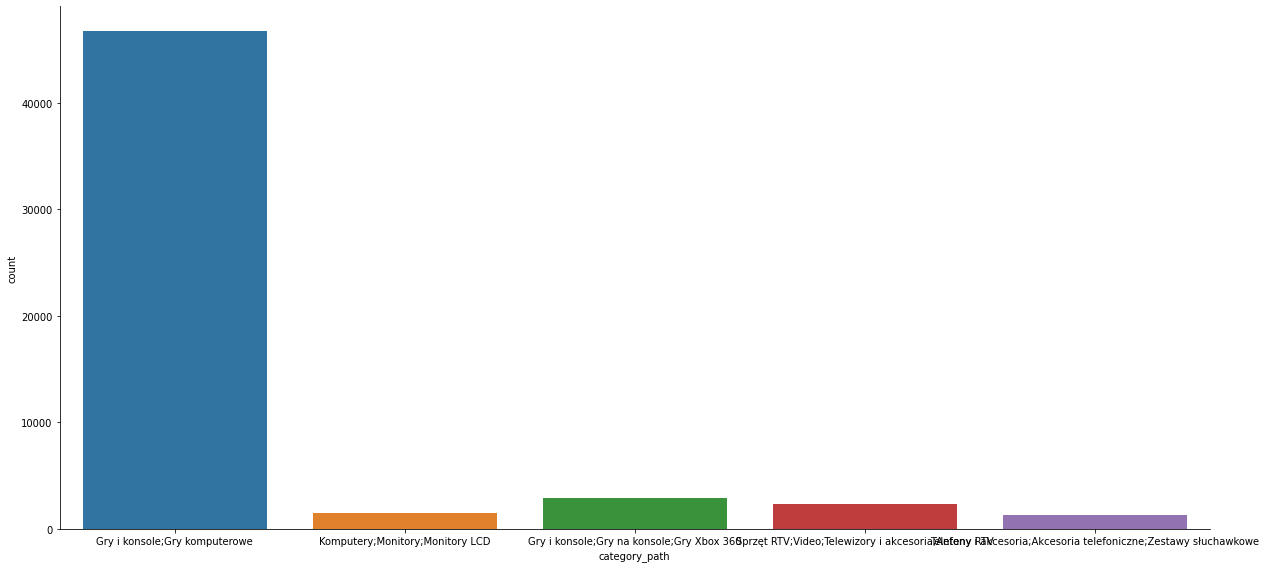

In [25]:
subSessionDF = sessionsDF.groupby('product_id').filter(lambda x : len(x) > sessionsDF['product_id'].value_counts().quantile(q=0.95)).copy()
subSessionProductDF = pd.merge(subSessionDF, productsDF, how='inner', on='product_id')
sns.catplot(data=subSessionProductDF, kind='count', x='product_name', height=8, aspect=2.2)
plt.xticks(rotation=90) # Rotate labels to make plot more readable

sns.catplot(data=subSessionProductDF, kind='count', x='category_path', height=8, aspect=2.2)
topProductsDF = productsDF.loc[productsDF['product_id'].isin(subSessionDF['product_id'].unique())]
print(topProductsDF['user_rating'].agg(['count', 'mean', 'max', 'min']))
topProductsDF

Okazuje się, że najpopularniejszymi produktami w sklepie są **Gry komputerowe**. Drugą najczęściej występującą kategorią są **Gry na konsolę**.

Bardzo popularne okazały się produkty o bardzo niskiej ocenie np. **Gra Call of Duty Black Ops**: ~4000 interakcji, ocena ~0.4.

Wśród 16 najpopularniejszych produktów średnia ocena wynosi ~3.1 .

Spojrzymy teraz całościowo na sesje i przeanalizujemy jakie są najczęściej oglądane i kupowane kategorie produktów. Ze względu, że "pełna kategoria" wprowadza zbyt dużą gradację,  na potrzeby tej analizy kategorie zostały zredukowane do 5 (zaproponowanych wcześniej podczas analizy atrybutu **category_path**).

Dane sesji podzieliśmy na dwa rozłączne podzbiory, w jednym znajdują się tylko obejrzane produkty, w drugim tylko produkty kupione (**event_type** odpowiednio **VIEW_PRODUCT** i **BUY_PRODUCT**).

Text(0.5, 1.0, 'Sessions with buy action')

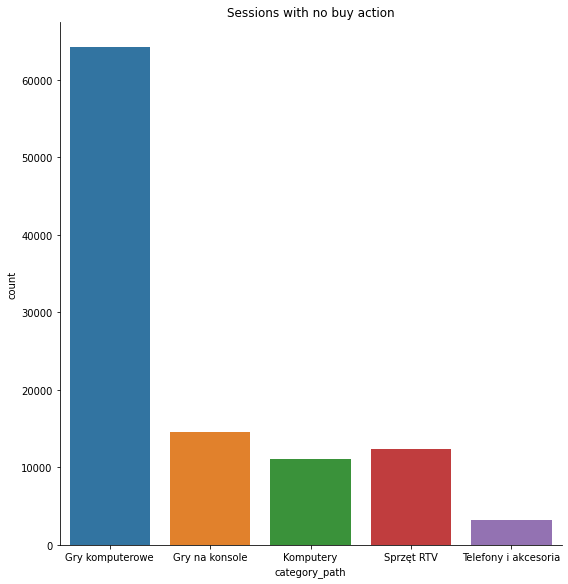

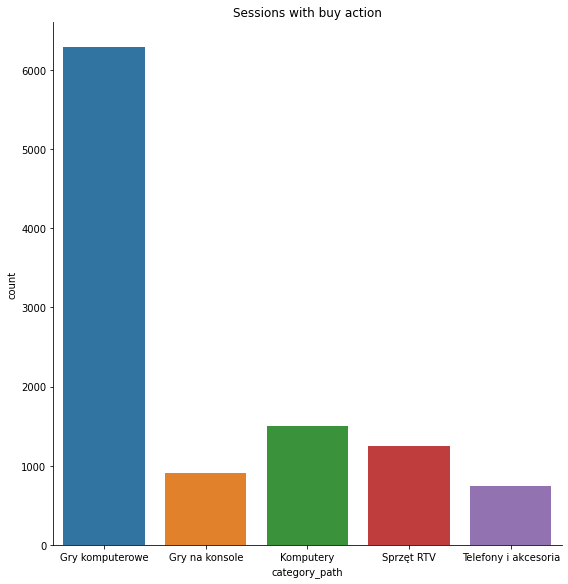

In [26]:
sessionProductDF = pd.merge(sessionsDF, productsDF, how='inner', on='product_id')
noBuySessions = sessionProductDF.loc[sessionProductDF['event_type'] == 'VIEW_PRODUCT'].copy()
buySessions = sessionProductDF.loc[sessionProductDF['event_type'] == 'BUY_PRODUCT'].copy()

# Reduce the number of product categories
noBuySessions['category_path'] = noBuySessions['category_path'].apply(castCategoryPath)
buySessions['category_path'] = buySessions['category_path'].apply(castCategoryPath)

sns.catplot(data=noBuySessions, kind='count', x='category_path', height=8)
plt.title("Sessions with no buy action")

sns.catplot(data=buySessions, kind='count', x='category_path', height=8)
plt.title("Sessions with buy action")

Jak widzimy, zarówno najczęściej oglądaną kategorią jak i najchętniej kupowaną są **Gry komputerowe**. Następnie praktycznie na równej pozycji znajdują się **Gry na konsole**, **Sprzęt RTV** i **Komputery**. Pomiędzy tą trójką, a faworytem istnieje jednak znacząca przepaść. Na ostatniej pozycji znajdziemy kategorię **Telefony i akcesoria**.

## Współczynnik informacji wzajemnej

Informacyjność danych jest istotna dla każdego problemu modelowania. Dla nas szczególnie istotne jest sprawdzenie, czy istnieje jakiś związek pomiędzy użytkownikiem, a przeglądanymi produktami.

Skalę makroskopową, tzn. czy użytkownik posiada jakieś indywidualne preferencje, możemy sprawdzić licząc współczynnik informacji wzajemnej dla atrybuty **user_id** i **category_path**.
Wspólczynnik policzyliśmy dla czterech formatów danych:
- sesje oglądania produktu, ścieżka kategorii zrzutowana do 5 kategorii głównych
- sesje oglądania produktu, pełna ścieżka kategorii
- sesje kupowania produktu, ścieżka kategorii zrzutowana do 5 kategorii głównych
- sesje kupwoania produktu, pełna ścieżka kategorii

In [27]:
from sklearn import metrics

noBuySessionProductDF = sessionProductDF.drop(sessionProductDF.index[sessionProductDF['event_type'] == 'BUY_PRODUCT']).copy()
buySessionProductDF = sessionProductDF.dropna(subset=['purchase_id']).copy()

castNoBuySessionProductDF = noBuySessionProductDF.copy()
castNoBuySessionProductDF['category_path'] = noBuySessionProductDF['category_path'].apply(castCategoryPath)

castBuySessionProductDF = buySessionProductDF.copy()
castBuySessionProductDF['category_path'] = buySessionProductDF['category_path'].apply(castCategoryPath)

print(f"Mutual information score for user_id and casted category_path (view events): {metrics.normalized_mutual_info_score(castNoBuySessionProductDF['user_id'], castNoBuySessionProductDF['category_path'])}")
print(f"Mutual information score for user_id and category_path (view events): {metrics.normalized_mutual_info_score(noBuySessionProductDF['user_id'], noBuySessionProductDF['category_path'])}")

print(f"Mutual information score for user_id and casted category_path (buy events): {metrics.normalized_mutual_info_score(castBuySessionProductDF['user_id'], castBuySessionProductDF['category_path'])}")
print(f"Mutual information score for user_id and category_path (buy events): {metrics.normalized_mutual_info_score(buySessionProductDF['user_id'], buySessionProductDF['category_path'])}")

Mutual information score for user_id and casted category_path (view events): 0.0042247757436152476
Mutual information score for user_id and category_path (view events): 0.01134813588066426
Mutual information score for user_id and casted category_path (buy events): 0.012983846815320063
Mutual information score for user_id and category_path (buy events): 0.0364898185058142


Wyznaczony współczynnik informacji wzajemnej (znormalizowany) ma bardzo niską wartość. Tylko jeden współczynnik ma wartość powyżej 0.02 i wynosi on ~0.036. Co ciekawe, okazuje się on być wyższy dla bardziej szczegółowych kategorii.

Po dłuższym zastanowieniu doszliśmy do wniosku, że nie jesteśmy pewni czy wskaźnik ten powinien mieć wysoką wartość. Na ten moment przyjmujemy te dane takimi jake są i ocenimi je w późniejszym etapie.  
Kolejnym pomysłem było sprawdzenie czy istnieje zależność między ilością interakcji (popularnością) z produktem a jego oceną. 
Tym razem ze względu na ciągłość atyrbutów i chęć wychwycenia bardziej liniowej zależności, policzyliśmy korelację liniową.  
Podobnie jak wcześniej policzyliśmy ją oddzielnie dla sesji przeglądania i zakupowych.

In [28]:
noBuySessionProductDF['user_rating'] = noBuySessionProductDF['user_rating'].apply(lambda x : round(x, 1))
noBuyProdCountSeries = noBuySessionProductDF.groupby(['product_id'])['user_id'].count().copy()
noBuyRatingSeries = noBuySessionProductDF.groupby(['product_id'])['user_rating'].unique().copy()
noBuyRatingSeries = noBuyRatingSeries.apply(lambda x : x[0])
print(f"Linear correlation between popularity of a product and user_rating (view events): {noBuyProdCountSeries.corr(noBuyRatingSeries)}")

buySessionProductDF['user_rating'] = buySessionProductDF['user_rating'].apply(lambda x : round(x, 1))
buyProdCountSeries = buySessionProductDF.groupby(['product_id'])['user_id'].count().copy()
buyRatingSeries = buySessionProductDF.groupby(['product_id'])['user_rating'].unique().copy()
buyRatingSeries = buyRatingSeries.apply(lambda x : x[0])
print(f"Linear correlation between popularity of a product and user_rating (buy events): {buyProdCountSeries.corr(buyRatingSeries)}")

Linear correlation between popularity of a product and user_rating (view events): 0.05492652941356389
Linear correlation between popularity of a product and user_rating (buy events): 0.1781114729161072


Okazuje się, że i wtym wypadku obserwujemy dość słabą korelację. Dla zdarzeń przglądania jest ona bliska zeru. Początkowo zakładaliśmy, że spodziewamy się tutaj slinej korelacji. Po przemyśleniach uważamy, że nie musi to być prawdą. 
Ocena produktu jest dobrowolna, stąd nie każdy użytkownik się na nią decyduje. Dodatkowo użytkownicy mogą przy swoich wyborach kierować się innymi (np. zewnętrznymi) kryteriami, a nie średnią oceną produktu w sklepie eSzoping.
Wszystko to sprawia, że ocena nie musi być reprezentatywna co do popularności produktu. 

Korelacja dla zdarzeń zakupu jest wielokrotnie wyższa co sugeruje, że ocena produktu w sklepie ma jakiś wpływ przy decyzji zakupowej użytkownika.

Postanowiliśmy jeszcze sprawdzić czy zachodzi korelacja liniowa pomiędzy ilością interakcji (popularnością) z danym produktem a jego ceną. Jak wcześniej współczynnik, policzyliśmy niezależenie dla sesji przegladania i zakupowych.

In [29]:
noBuyPriceSeries = noBuySessionProductDF.groupby(['product_id'])['price'].unique().copy()
noBuyPriceSeries = noBuyPriceSeries.apply(lambda x : x[0])
print(f"Linear correlation between popularity of a product and price (view events): {noBuyProdCountSeries.corr(noBuyPriceSeries)}")

buyPriceSeries = buySessionProductDF.groupby(['product_id'])['price'].unique().copy()
buyPriceSeries = buyPriceSeries.apply(lambda x : x[0])
print(f"Linear correlation between popularity of a product and price (buy events): {buyProdCountSeries.corr(buyPriceSeries)}")

Linear correlation between popularity of a product and price (view events): 0.045856597412131626
Linear correlation between popularity of a product and price (buy events): 0.053533667745115546


Wyznaczone współczynniki ponownie są bliskie zeru.
Sugeruje to, że w przypadku użytkowników sklepu eSzoping cena produktu nie gra większej roli, zarówno przy ogladaniu produktów jak i ich zakupie.
Oznacza to, że ten argument jest potencjalnie zbędny przy tworzeniu modelu.

### Badanie gęstości macierzy interakcji
Postanowiliśmy sprawdzić również jak wyglada gęstość otrzymanych danych dla zadania predykcji. Utworzyliśmy macierz, której kolumny odpowiadają wszystkim produktom w ofercie, a wiersze poszczególnym użytkonikom.  
Jeżeli użytkownik wszedł w interakcje z danym produktem (obejrzał go lub kupił), w odpowidającej komórce będzie 1, w przeciwnym wypadku komórka pozostanie pusta. Dla tak utworzonej macierzy policzyliśmy gęstość.

In [30]:
df = sessionsDF.drop(columns=["session_id", "timestamp", "event_type", "offered_discount", "purchase_id"])
df["hit"] = 1
heatMapDF = pd.pivot_table(df, index="user_id", columns="product_id", values="hit")
print("Sparse matrix density: " + str((heatMapDF.size - heatMapDF.isna().sum().sum())/heatMapDF.size))


Sparse matrix density: 0.4485266457680251


Gęstość powyższej macierzy wynosi ~44,8% co jest wartością wystarczającą dla zadania rekomendacji.

# Podsumowanie

Podsumowując powyższą analizę:
* W dostarczonych danych nie wykryto oczywistych błędów, takich jak: braki wartości, błędne wartości atrybutów. Jedyne co zwróciło naszą uwagę to trzy produkty, których koszt wynosi 1.
* Dostarczone dane pochodzą z okresu 24 miesięcy co daje nam reprezentatywny przedział czasowy.
* Kategorie produktów są bardzo nierównomierne. Nawet po zredukowaniu ilości grup do 5 najgorszy współczynnik niezbalansowania wynosi ~1:14. Możemy próbować temu zaradzić rozbijając kategorię większosciową (Gry komputerowe), na mniejsze np. na gatunki gier. Ostateczną decyzję podejmiemy analizując zachowanie modeli.
* W danych zachodzi również duża nierównomierność w popularności produktów mierzonej jako liczba interakcji. Podobnie sytuacja wygląda z kategoriami, widzimy bezpośrednią korelację między liczebnością grupy (zredukowanej), a jej popularnością.
* Współczynnik informacji wzajemnej między *user_id*, a *category_path* pokazał, że użytkownicy nie wydają się mieć z góry określony preferencji.
* Współczynniki korelacji liniowej dla ilości interakcji z danym produktem, a jego oceną są bliskie zeru, podobnie jak dla współczynnika między ilością interakcji, a ceną produkty.
Oznacza to, że te atrybuty te są dla nas mało interesujące (niska informatywność).
* Policzone współczynniki sugerują brak spodziewanych zależności. Nie oznacza to koniecznie błędów w danych. Ponowną iterację przeprowadzimy po wytworzeniu pierwszych modeli.
* Sprawdziliśmy również jak wygląda gestość macierzy interakcji, kluczowy wskaźnik dla problemu rekomendacji - nie budzi on żadnych zastrzeżeń.